## Loading Data

In [2]:
import pandas as pd
import numpy as np
import requests
import re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
from wordcloud import WordCloud
from collections import Counter

In [3]:
Billboard = pd.read_csv('Billboard100.csv')
Billboard = Billboard[Billboard['Year'] <= 2019]

Billboard['Lyrics'].fillna('', inplace=True)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

Billboard['Lyrics'] = Billboard['Lyrics'].apply(remove_punctuation)
Billboard['Tokenized_Lyrics'] = Billboard['Lyrics'].apply(word_tokenize)
Billboard['Word_Count'] = Billboard['Tokenized_Lyrics'].apply(len)

In [4]:
Billboard['Artist'].nunique()

2980

## Word Counts

In [4]:
#Number of songs
print(len( Billboard['Lyrics']))

#Number of missing songs
print(len( Billboard['Lyrics'][pd.isna(Billboard['Lyrics'])] ))

#Average words in a song
Billboard['Word_Count'] = Billboard['Tokenized_Lyrics'].apply(len)
print(round(Billboard['Word_Count'].mean(),2))

#Average unique words in a song
def count_unique_words(word_list):
    return len(set(word_list))

Billboard['Unique_Word_Count'] = Billboard['Tokenized_Lyrics'].apply(count_unique_words)
print(round(Billboard['Unique_Word_Count'].mean(), 2))

6001
0
308.6
105.99


## Word Frequencies

In [6]:
#Tokenizing the lyrics column without stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return [word for word in text if word.lower() not in stop_words]
Billboard['Tokenized_Lyrics'] = Billboard['Tokenized_Lyrics'].apply(remove_stopwords)

In [7]:
#Finding the most said words
frequency = defaultdict(int)
for tokens in Billboard['Tokenized_Lyrics']:
    for token in tokens:
        frequency[token] += 1

Word_frequency = pd.Series(frequency)
Word_frequency = Word_frequency.sort_values(ascending=False)
Common_words = pd.DataFrame({'Frequency': Word_frequency.values,
                             'Rank': np.arange(Word_frequency.size) + 1},
                             index=Word_frequency.index)

Common_words.head(10)

,Frequency,Rank
im,16940,1
love,16821,2
dont,13133,3
know,12900,4
like,12538,5
na,12291,6
oh,11851,7
got,11621,8
baby,10959,9
get,8926,10


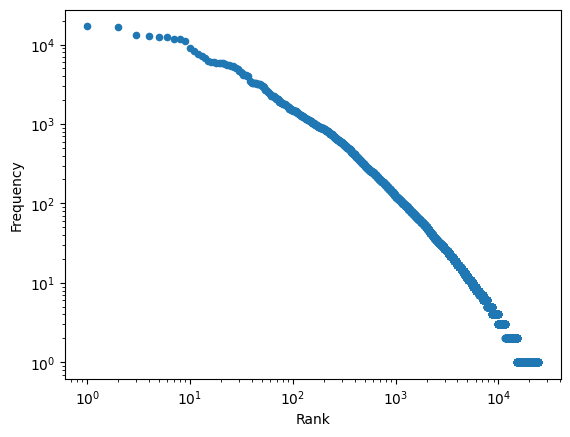

In [8]:
Common_words.plot(x='Rank', y='Frequency', kind="scatter")
plt.yscale('log')
plt.xscale('log')
plt.show()

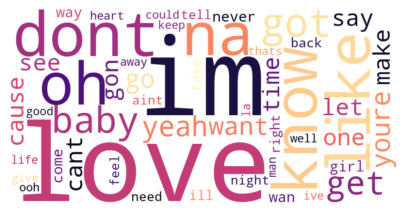

In [10]:
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, colormap='magma')
wordcloud.generate_from_frequencies(frequencies=Word_frequency)
plt.figure(figsize=(5, 3))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## ngrams

In [ ]:
from operator import itemgetter
def get_top_ngrams(corpus, ngram_val=1, limit=5):
    tokens = nltk.word_tokenize(corpus)
    my_ngrams = list(ngrams(tokens, ngram_val))
    ngrams_freq_dist = nltk.FreqDist(my_ngrams)
    sorted_ngrams_fd = sorted(ngrams_freq_dist.items(), key=itemgetter(1), reverse=True)
    sorted_ngrams = sorted_ngrams_fd[0:limit]
    sorted_ngrams = [(' '.join(text), freq) for text, freq in sorted_ngrams]
    return sorted_ngrams

from operator import itemgetter
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
songs = ' '.join(Billboard["Lyrics"].apply(lambda x: ' '.join(tokenizer.tokenize(x))))

get_top_ngrams(corpus=songs, ngram_val=2, limit=10)
#get_top_ngrams(corpus=songs, ngram_val=3, limit=10)

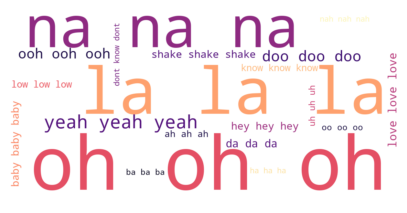

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

lyrics_text = ' '.join(Billboard["Lyrics"])

count_bigrams = CountVectorizer(stop_words='english', ngram_range=(2,2))
count_bigrams.fit([lyrics_text])

freq_bigrams = count_bigrams.transform([lyrics_text]).toarray()[0]
feature_names = count_bigrams.get_feature_names_out()
bigram_freq_dict = dict(zip(feature_names, freq_bigrams))

wordcloud = WordCloud(background_color='white', height=600, min_font_size=2, width=1200, max_words=20, colormap="magma")
wordcloud = wordcloud.generate_from_frequencies(bigram_freq_dict)

plt.figure(figsize=(5,3))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
plt.show()

## Love Songs

In [60]:
#How many songs does the word love appear in?
love_song_count = 0
for tokens in Billboard['Tokenized_Lyrics']:
    if 'love' in tokens:
        love_song_count += 1
print(love_song_count)

#What is the average number of times the word love appears in songs?
if 'love' in frequency:
    average_love_frequency = frequency['love'] / len(Billboard)
    print(round(average_love_frequency,2))

3299
2.8


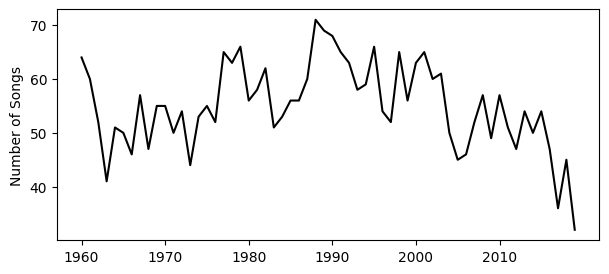

In [33]:
love_songs_per_year = {}
Billboard['Year'] = Billboard['Year'].astype(int)

for year in range(Billboard['Year'].min(), Billboard['Year'].max() + 1):
    songs_in_year = Billboard[Billboard['Year'] == year]
    love_songs_count = sum('love' in tokens for tokens in songs_in_year['Tokenized_Lyrics'])
    love_songs_per_year[year] = love_songs_count

love_songs_df = pd.DataFrame(list(love_songs_per_year.items()), columns=['Year', 'Love_Songs'])

plt.figure(figsize=(7, 3))
plt.plot(love_songs_df['Year'], love_songs_df['Love_Songs'], color='black')
plt.ylabel('Number of Songs')
plt.grid(False)
plt.xticks(range(Billboard['Year'].min(), Billboard['Year'].max() + 1, 10))
plt.show()


## Word Frequency Overtime

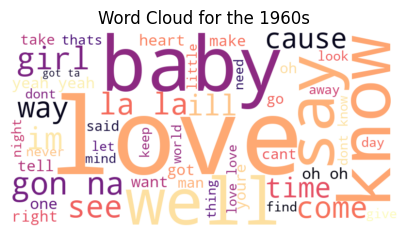

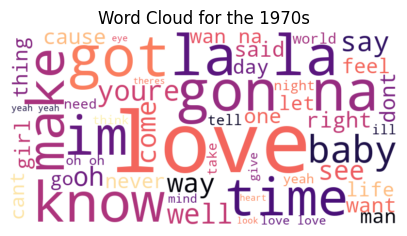

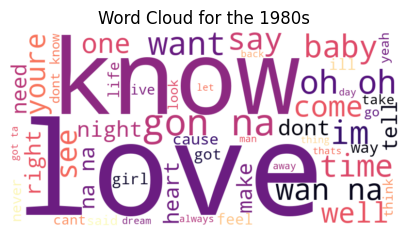

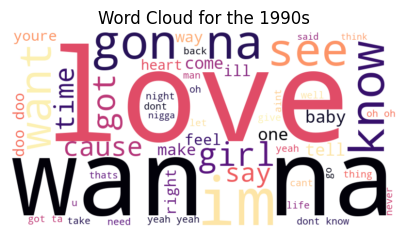

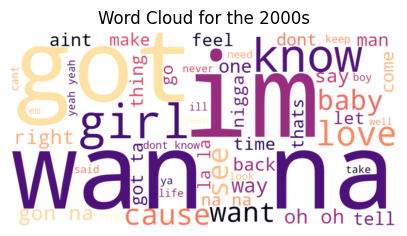

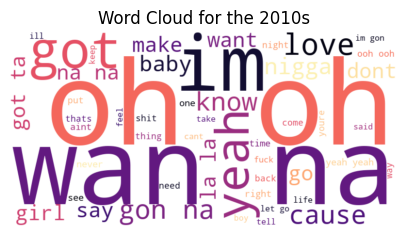

In [34]:
Billboard['Decade'] = (Billboard['Year'] // 10) * 10

decade_groups = Billboard.groupby('Decade')
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, colormap='magma')

for decade, group in decade_groups:
    combined_lyrics = ' '.join(group['Tokenized_Lyrics'].sum())
    wordcloud.generate(combined_lyrics)
    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for the {decade}s')
    plt.axis('off')
    plt.show()

## Swearing Frequency

In [14]:
def count_swears(tokens, profanity_file_path):
    with open(profanity_file_path, 'r') as file:
        swear_words = [line.strip().lower() for line in file]
    return sum(word.lower() in swear_words for word in tokens)

profanity_file_path = "/Users/aaronharper/Documents/Spring_2024/BZAN_557/Project/badwords.txt"
Billboard['Swear_Word_Count'] = Billboard['Tokenized_Lyrics'].apply(count_swears, args=(profanity_file_path,))

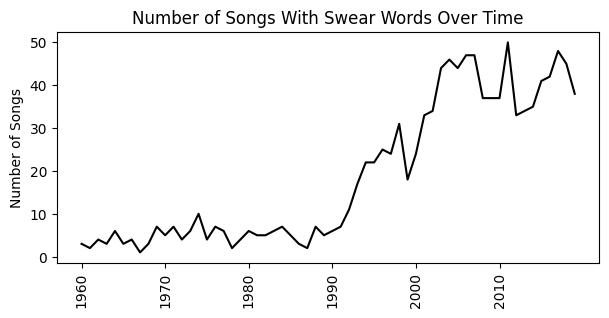

In [35]:
year_groups = Billboard.groupby('Year')
songs_with_swears_per_year = year_groups['Swear_Word_Count'].apply(lambda x: (x > 0).sum())

plt.figure(figsize=(7, 3))
plt.plot(songs_with_swears_per_year.index, songs_with_swears_per_year.values, color='black')
plt.title('Number of Songs With Swear Words Over Time')
plt.ylabel('Number of Songs')
plt.xticks(range(Billboard['Year'].min(), Billboard['Year'].max() + 1, 10), rotation=90)
plt.grid(False)
plt.show()

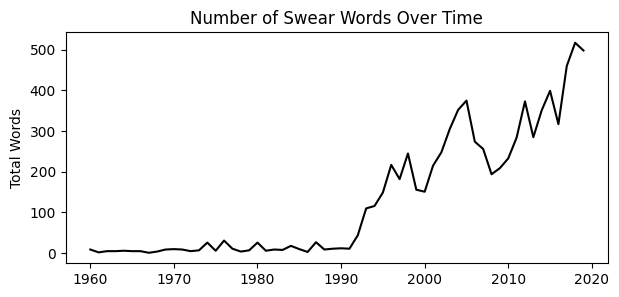

In [39]:
year_groups = Billboard.groupby('Year')
swear_words_per_year = year_groups['Swear_Word_Count'].sum()

plt.figure(figsize=(7, 3))
plt.plot(swear_words_per_year.index, swear_words_per_year.values, color='black')
plt.title('Number of Swear Words Over Time')
plt.ylabel('Total Words')
plt.grid(False)
plt.show()

## Topic Modeling

In [41]:
from gensim.parsing.preprocessing import preprocess_string
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models import LsiModel
from gensim.models import Nmf

lyrics = Billboard['Lyrics'].dropna().values.tolist()
lyrics_tokenized = [lyric.split() for lyric in lyrics]

lyrics_text = [' '.join(tokens) for tokens in lyrics_tokenized]
lyrics_preprocessed = [preprocess_string(doc) for doc in lyrics_text]

dictionary = corpora.Dictionary(lyrics_preprocessed)

lyrics_bow = [dictionary.doc2bow(text) for text in lyrics_preprocessed]

tfidf_model = TfidfModel(lyrics_bow)
lyrics_tfidf = tfidf_model[lyrics_bow]

lsi = LsiModel(lyrics_tfidf,
               id2word=dictionary,
               num_topics=4)
lsi.print_topics()

# nmf = Nmf(lyrics_tfidf,
#           id2word=dictionary,
#           num_topics=4)
# nmf.print_topics()

[(0,
  '0.228*"love" + 0.216*"babi" + 0.152*"dont" + 0.151*"want" + 0.135*"your" + 0.134*"girl" + 0.134*"yeah" + 0.128*"wanna" + 0.127*"ill" + 0.126*"know"'),
 (1,
  '-0.277*"love" + 0.231*"nigga" + 0.216*"danc" + 0.213*"yeah" + -0.185*"heart" + 0.178*"wanna" + 0.158*"girl" + 0.144*"aint" + 0.131*"fuck" + -0.130*"ill"'),
 (2,
  '-0.580*"babi" + -0.572*"ooh" + -0.169*"love" + 0.140*"nigga" + -0.090*"yeah" + 0.087*"fuck" + -0.085*"want" + 0.079*"bitch" + 0.074*"shit" + 0.066*"aint"'),
 (3,
  '0.739*"ooh" + -0.437*"babi" + -0.216*"tonight" + -0.184*"wanna" + -0.149*"danc" + 0.083*"nigga" + -0.078*"want" + -0.077*"let" + 0.069*"iv" + -0.064*"need"')]

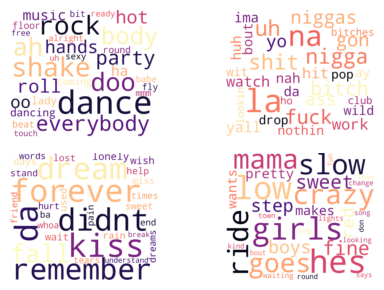

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt

count = CountVectorizer(stop_words='english', min_df=10, max_df=500)
X_vect = count.fit_transform(Billboard['Lyrics'])

n_topics = 4
n_words_display = 30
lda = LatentDirichletAllocation(n_components=n_topics)
X_lda = lda.fit_transform(X_vect)
indices = (-lda.components_).argsort(axis=1)[:, :n_words_display]
vocab = np.array(count.get_feature_names_out())

fig, axes = plt.subplots(2, 2, figsize=(5, 3))
axes = axes.ravel()

for i in range(n_topics):
    
    weights = lda.components_[i][indices[i]]
    words = vocab[indices[i, :]]
    dictionary = dict(zip(words, weights))
    
    wordcloud = WordCloud(background_color='white', height=1200, min_font_size=5,
                          width=1400, colormap='magma',
                          max_words=n_words_display, relative_scaling=0.5,
                          max_font_size=300)
    wordcloud = wordcloud.generate_from_frequencies(dictionary)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Word2Vec

In [64]:
from gensim.models import Word2Vec

lyrics = Billboard['Lyrics'].dropna().values.tolist()
lyrics_tokenized = [lyric.split() for lyric in lyrics]

model = Word2Vec(sentences=lyrics_tokenized, vector_size=100, window=5, min_count=5, workers=4)

In [65]:
focal_words = ['im', 'know', 'dont', 'love', 'money']

for focal_word in focal_words:
    if focal_word in model.wv.key_to_index:
        print(f"\n{focal_word} : =======")
        sim_words = model.wv.most_similar(positive=focal_word, topn=10)
        for word, similarity in sim_words:
            print(f"{word}\t{similarity:.2f}")



im : =======
youre	0.58
am	0.54
nothings	0.50
whos	0.50
m	0.49
everythings	0.47
hes	0.44
feelin	0.43
being	0.42
shes	0.42

know : =======
understand	0.67
realize	0.59
think	0.58
care	0.57
show	0.56
really	0.55
see	0.54
say	0.52
forget	0.51
tell	0.51

dont : =======
wont	0.58
anymore	0.50
doesnt	0.50
please	0.48
cant	0.48
try	0.47
should	0.47
didnt	0.46
wanna	0.46
wouldnt	0.45

love : =======
baby	0.60
true	0.58
loving	0.58
you	0.53
touch	0.52
because	0.51
believe	0.50
fall	0.50
heart	0.50
life	0.49

money : =======
respect	0.60
cash	0.57
dough	0.54
sex	0.53
power	0.52
price	0.51
fame	0.51
chicks	0.49
bitch	0.48
pay	0.47


## Similar Songs

In [23]:
import nltk
import re
import numpy as np

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    tokens = nltk.word_tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(Billboard['Lyrics']))
len(norm_corpus)

6001

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
tfidf_matrix = tf.fit_transform(norm_corpus)
tfidf_matrix.shape

(6001, 88828)

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

doc_sim = cosine_similarity(tfidf_matrix)
doc_sim_df = pd.DataFrame(doc_sim)
doc_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,6000
0,1.000000,0.014445,0.011316,0.008711,0.013290,0.004808,0.027751,0.011576,0.003502,0.004105,...,0.003949,0.001939,0.0,0.051390,0.014663,0.03155,0.032365,0.007203,0.002190,0.011320
1,0.014445,1.000000,0.025270,0.016923,0.018139,0.032943,0.017378,0.022002,0.003015,0.012549,...,0.009095,0.008979,0.0,0.010370,0.022720,0.00000,0.012742,0.024680,0.016693,0.015068
2,0.011316,0.025270,1.000000,0.015494,0.006172,0.017279,0.008411,0.027032,0.007826,0.006293,...,0.018361,0.007154,0.0,0.012614,0.018112,0.00000,0.022849,0.029482,0.070768,0.023831
3,0.008711,0.016923,0.015494,1.000000,0.014841,0.007458,0.010009,0.005194,0.019291,0.019419,...,0.002252,0.008973,0.0,0.003019,0.013553,0.00000,0.007379,0.000724,0.003536,0.001234
4,0.013290,0.018139,0.006172,0.014841,1.000000,0.004186,0.020883,0.002479,0.003848,0.000655,...,0.000649,0.011229,0.0,0.001050,0.009296,0.00000,0.004280,0.008439,0.003078,0.004540


In [26]:
songs_list = Billboard['Title'].values
songs_list, songs_list.shape

(array(['theme from a summer place', "he'll have to go", "cathy's clown",
        ..., 'all to myself', 'boyfriend', 'walk me home'], dtype=object),
 (6001,))

In [27]:
song_idx = np.where(songs_list == 'boyfriend')[0][0]
song_similarities = doc_sim_df.iloc[song_idx].values
similar_song_idxs = np.argsort(-song_similarities)[1:6]
similar_songs = songs_list[similar_song_idxs]
similar_songs

array(["should've never let you go", 'never let you go', 'what it takes',
       'let it go', 'boyfriend'], dtype=object)

In [28]:
def song_recommender(song_title, songs=songs_list, doc_sims=doc_sim_df):
    song_idx = np.where(songs == song_title)[0][0]
    song_similarities = doc_sims.iloc[song_idx].values
    similar_song_idxs = np.argsort(-song_similarities)[1:6]
    similar_songs = songs[similar_song_idxs]
    return similar_songs

In [30]:
song_recommender('smooth criminal')

array(['wildside', 'polk salad annie', "u don't have to call",
       "sign o' the times", "it's not right but it's okay"], dtype=object)